# EDA – CppSATD Dataset
**Self-Admitted Technical Debt (SATD) in C++ Projects**

This notebook performs a full exploratory data analysis on the `manual_annotations.csv` dataset.

## 1. Setup & Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from collections import Counter
import re
import warnings

warnings.filterwarnings('ignore')

# Plotting style
sns.set_theme(style='whitegrid', palette='muted')
plt.rcParams.update({'figure.dpi': 120, 'font.size': 11})

print('Libraries loaded successfully.')

Libraries loaded successfully.


## 2. Load Data

In [2]:
DATA_PATH = '../data/data_and_scripts/data_and_scripts/manual_annotations.csv'

df = pd.read_csv(DATA_PATH, low_memory=False)
print(f'Dataset shape: {df.shape}')
df.head()


Dataset shape: (35098, 7)


,comment_id,commenttext,preceding_code,succeeding_code,file_id,projectname,manual_annotation
0,21897,// If no suitable candidate from the same peer...,NaN,\n const auto cpfp_candidates_different_pee...,835.cpp,bitcoin,NON-SATD
1,302,//! Utility function to add all of a transacti...,NaN,"\nvoid AddCoins(CCoinsViewCache& cache, const ...",1023.h,bitcoin,REQUIREMENT
2,811,"/** Work around circular dependency, as well a...",NaN,\nconst std::vector<unsigned char>& GetObfusca...,1041.h,bitcoin,DESIGN/CODE
3,1830,// TODO(sanjay): Merge with existing error?,"static bool SaveError(char** errptr, const Sta...",\n free(*errptr);\n *errptr = strdup(s.T...,1092.cc,bitcoin,DESIGN/CODE
4,2709,// TODO(sanjay): Suppress dups?,Slice* mkey = const_cast<Slice*>(keys);\n f...,"\n }\n user_policy_->CreateFilter(keys, n, d...",1134.cc,bitcoin,DESIGN/CODE


## 3. Dataset Overview

In [3]:
print('=== Column names ===')
print(df.columns.tolist())

print('\n=== Data types ===')
print(df.dtypes)

print('\n=== Memory usage ===')
print(df.memory_usage(deep=True).sum() / 1024**2, 'MB')

=== Column names ===
['comment_id', 'commenttext', 'preceding_code', 'succeeding_code', 'file_id', 'projectname', 'manual_annotation']

=== Data types ===
comment_id            int64
commenttext          object
preceding_code       object
succeeding_code      object
file_id              object
projectname          object
manual_annotation    object
dtype: object

=== Memory usage ===
29.863046646118164 MB


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35098 entries, 0 to 35097
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   comment_id         35098 non-null  int64 
 1   commenttext        35098 non-null  object
 2   preceding_code     18228 non-null  object
 3   succeeding_code    31867 non-null  object
 4   file_id            35098 non-null  object
 5   projectname        35098 non-null  object
 6   manual_annotation  35098 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.9+ MB


In [5]:
df.describe(include='all')

,comment_id,commenttext,preceding_code,succeeding_code,file_id,projectname,manual_annotation
count,35098.000000,35098,18228,31867,35098,35098,35098
unique,NaN,30598,16441,29132,9341,5,6
top,NaN,// from @llvm-project,},\n},537.cpp,tensorflow,NON-SATD
freq,NaN,298,613,406,156,14687,22029
mean,83787.677446,NaN,NaN,NaN,NaN,NaN,NaN
std,64994.898233,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,30884.250000,NaN,NaN,NaN,NaN,NaN,NaN
50%,70720.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,118669.500000,NaN,NaN,NaN,NaN,NaN,NaN


## 4. Missing Values

                   Missing Count  Missing %
comment_id                     0       0.00
commenttext                    0       0.00
preceding_code             16870      48.07
succeeding_code             3231       9.21
file_id                        0       0.00
projectname                    0       0.00
manual_annotation              0       0.00


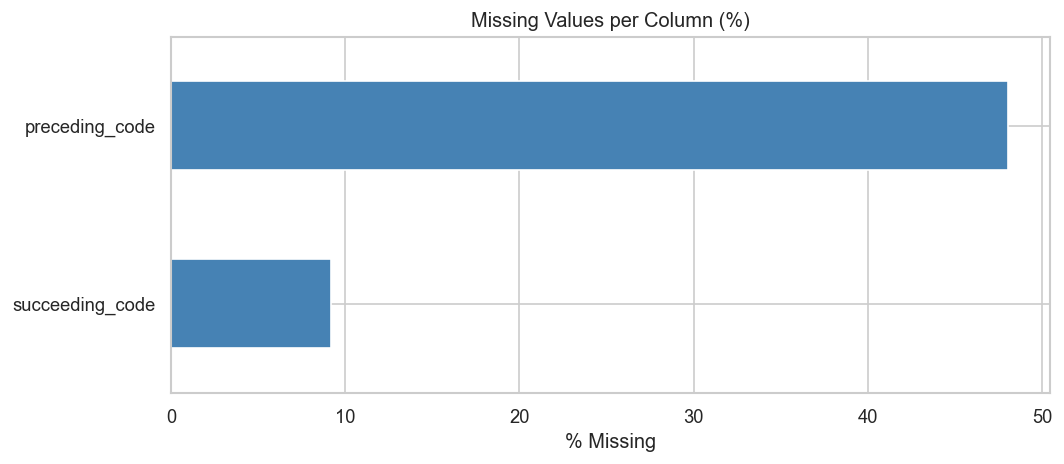

In [6]:
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)

missing_df = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_pct})
print(missing_df)

# Visualise
fig, ax = plt.subplots(figsize=(9, 4))
missing_pct[missing_pct > 0].sort_values().plot(kind='barh', ax=ax, color='steelblue')
ax.set_title('Missing Values per Column (%)')
ax.set_xlabel('% Missing')
plt.tight_layout()
plt.show()

## 5. Target Variable – `manual_annotation`

In [7]:
label_counts = df['manual_annotation'].value_counts()
label_pct    = df['manual_annotation'].value_counts(normalize=True) * 100

label_summary = pd.DataFrame({'Count': label_counts, 'Percentage (%)': label_pct.round(2)})
print(label_summary)

                   Count  Percentage (%)
manual_annotation                       
NON-SATD           22029           62.76
DESIGN/CODE         8242           23.48
REQUIREMENT         3917           11.16
DEFECT               442            1.26
TEST                 422            1.20
DOCUMENTATION         46            0.13


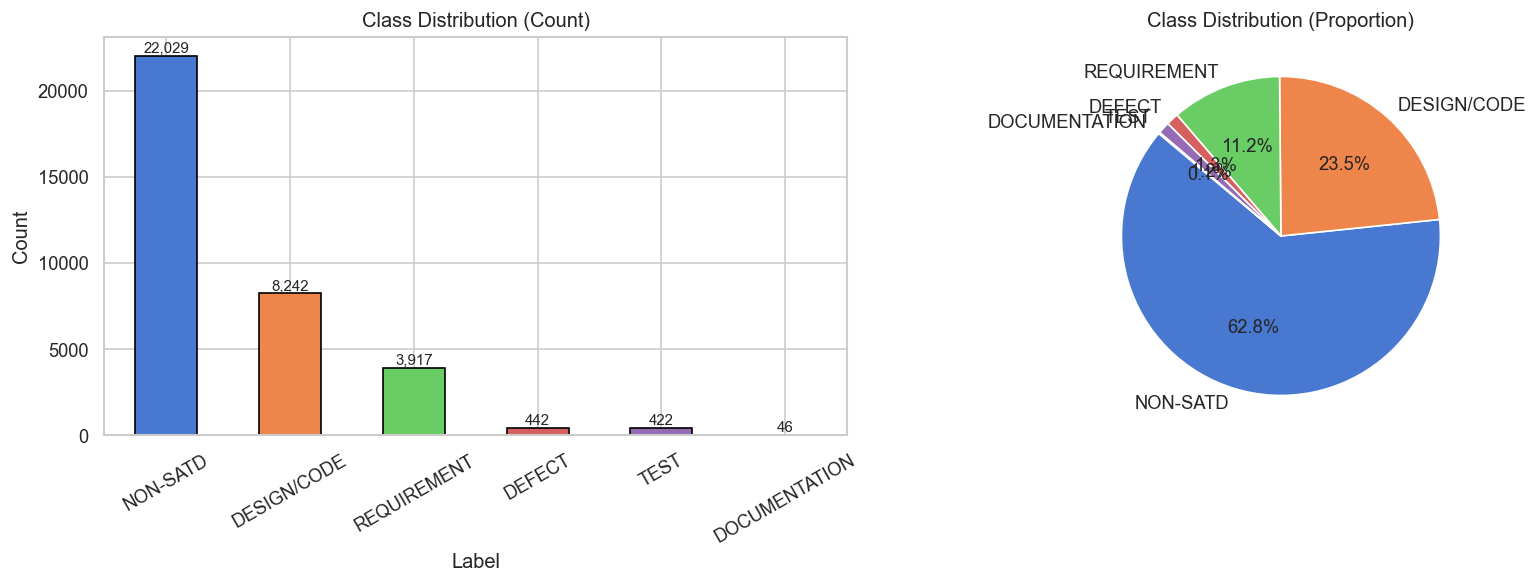

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
label_counts.plot(kind='bar', ax=axes[0], color=sns.color_palette('muted', len(label_counts)),
                  edgecolor='black')
axes[0].set_title('Class Distribution (Count)')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=30)
for p in axes[0].patches:
    axes[0].annotate(f'{int(p.get_height()):,}',
                     (p.get_x() + p.get_width()/2, p.get_height()),
                     ha='center', va='bottom', fontsize=9)

# Pie chart
axes[1].pie(label_counts, labels=label_counts.index,
            autopct='%1.1f%%', startangle=140,
            colors=sns.color_palette('muted', len(label_counts)))
axes[1].set_title('Class Distribution (Proportion)')

plt.tight_layout()
plt.show()

## 6. Project Distribution

In [9]:
proj_counts = df['projectname'].value_counts()
proj_pct    = df['projectname'].value_counts(normalize=True) * 100

proj_summary = pd.DataFrame({'Count': proj_counts, 'Percentage (%)': proj_pct.round(2)})
print(proj_summary)

              Count  Percentage (%)
projectname                        
tensorflow    14687           41.85
swift          9871           28.12
godot          8545           24.35
bitcoin        1341            3.82
react-native    654            1.86


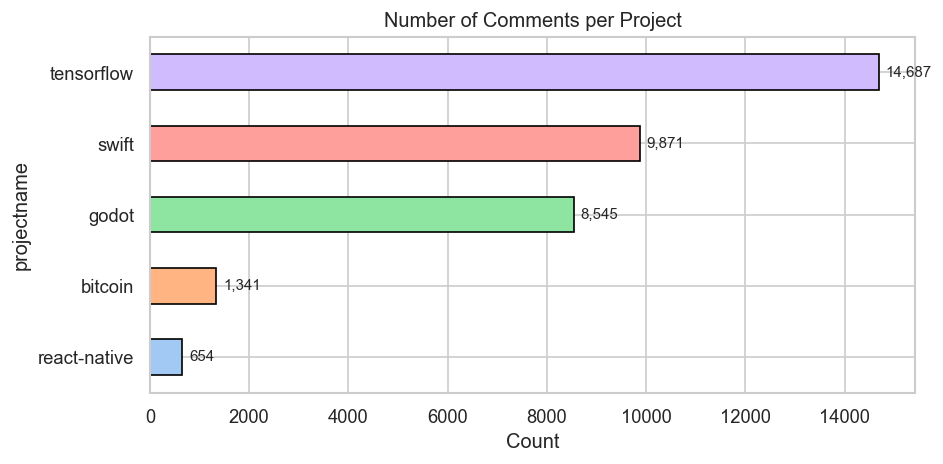

In [10]:
fig, ax = plt.subplots(figsize=(8, 4))
proj_counts.sort_values().plot(kind='barh', ax=ax,
                                color=sns.color_palette('pastel', len(proj_counts)),
                                edgecolor='black')
ax.set_title('Number of Comments per Project')
ax.set_xlabel('Count')
for p in ax.patches:
    ax.annotate(f'{int(p.get_width()):,}',
                (p.get_width(), p.get_y() + p.get_height()/2),
                ha='left', va='center', fontsize=9, xytext=(4, 0),
                textcoords='offset points')
plt.tight_layout()
plt.show()

## 7. Label Distribution per Project

In [11]:
cross = pd.crosstab(df['projectname'], df['manual_annotation'])
cross_norm = pd.crosstab(df['projectname'], df['manual_annotation'], normalize='index') * 100
print('=== Absolute counts ===')
print(cross)
print('\n=== Row-normalised (%) ===')
print(cross_norm.round(2))

=== Absolute counts ===
manual_annotation  DEFECT  DESIGN/CODE  DOCUMENTATION  NON-SATD  REQUIREMENT  \
projectname                                                                    
bitcoin                16          121              0      1153           42   
godot                 102         1293             11      6528          589   
react-native            7          164              1       414           55   
swift                 106         2960              5      5550         1240   
tensorflow            211         3704             29      8384         1991   

manual_annotation  TEST  
projectname              
bitcoin               9  
godot                22  
react-native         13  
swift                10  
tensorflow          368  

=== Row-normalised (%) ===
manual_annotation  DEFECT  DESIGN/CODE  DOCUMENTATION  NON-SATD  REQUIREMENT  \
projectname                                                                    
bitcoin              1.19         9.02       

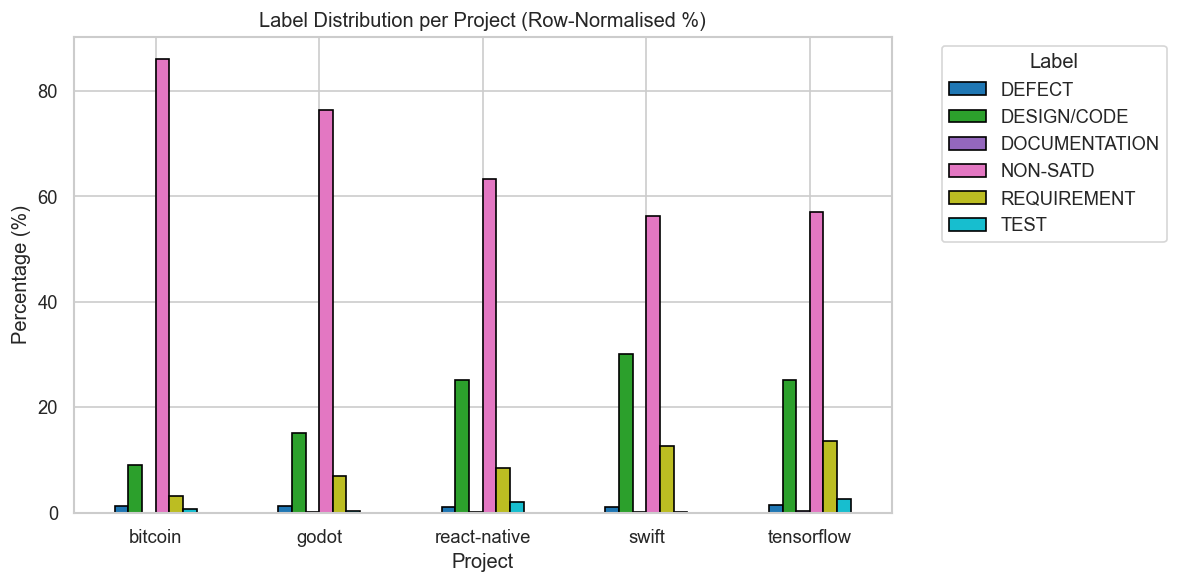

In [12]:
cross_norm.plot(kind='bar', figsize=(10, 5), colormap='tab10', edgecolor='black')
plt.title('Label Distribution per Project (Row-Normalised %)')
plt.xlabel('Project')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)
plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 8. Comment Text Analysis

In [13]:
# Fill NaN
df['commenttext'] = df['commenttext'].fillna('')

# Character length
df['comment_char_len'] = df['commenttext'].str.len()

# Word count (split on whitespace)
df['comment_word_count'] = df['commenttext'].str.split().str.len()

# Line count
df['comment_line_count'] = df['commenttext'].str.count('\n') + 1

print(df[['comment_char_len', 'comment_word_count', 'comment_line_count']].describe().round(2))

       comment_char_len  comment_word_count  comment_line_count
count          35098.00            35098.00            35098.00
mean             182.49               28.37                3.69
std              488.09               70.34               11.76
min                3.00                1.00                1.00
25%               41.00                6.00                1.00
50%               77.00               13.00                1.00
75%              173.00               28.00                3.00
max            32767.00             4218.00              725.00


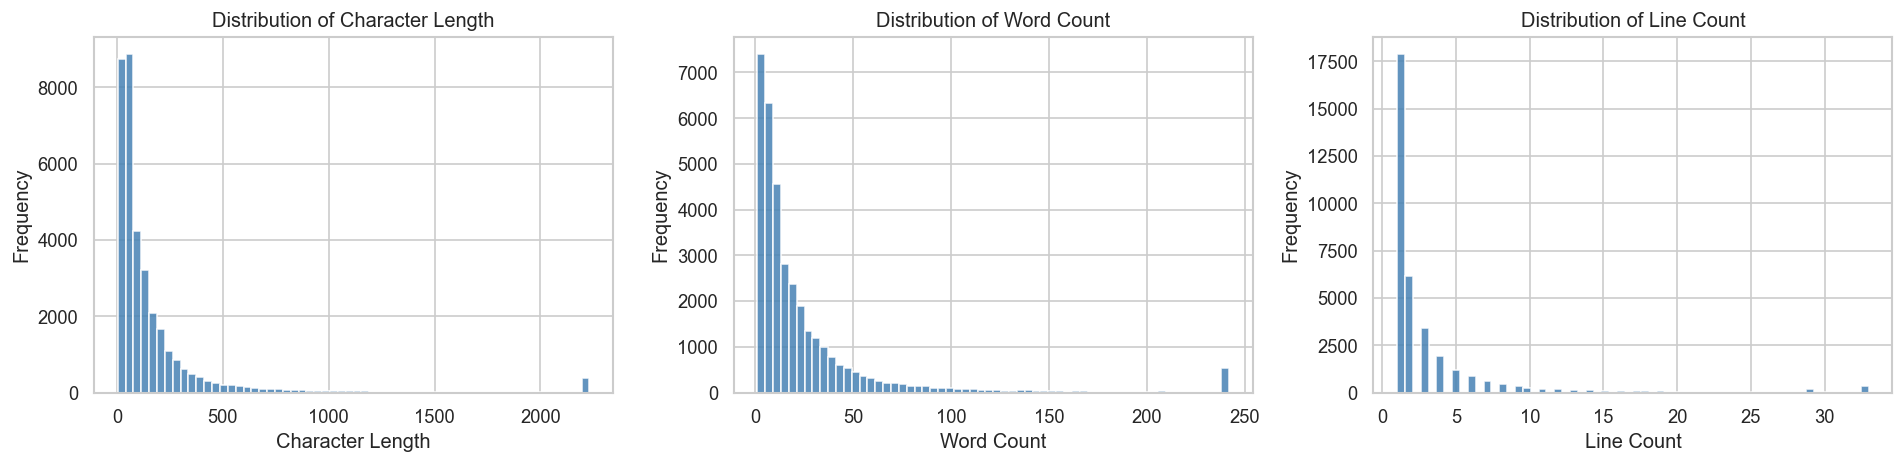

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

metrics = [
    ('comment_char_len',   'Character Length'),
    ('comment_word_count', 'Word Count'),
    ('comment_line_count', 'Line Count'),
]

for ax, (col, title) in zip(axes, metrics):
    cap = df[col].quantile(0.99)  # cap at 99th percentile for readability
    data = df[col].clip(upper=cap)
    ax.hist(data, bins=60, color='steelblue', edgecolor='white', alpha=0.85)
    ax.set_title(f'Distribution of {title}')
    ax.set_xlabel(title)
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

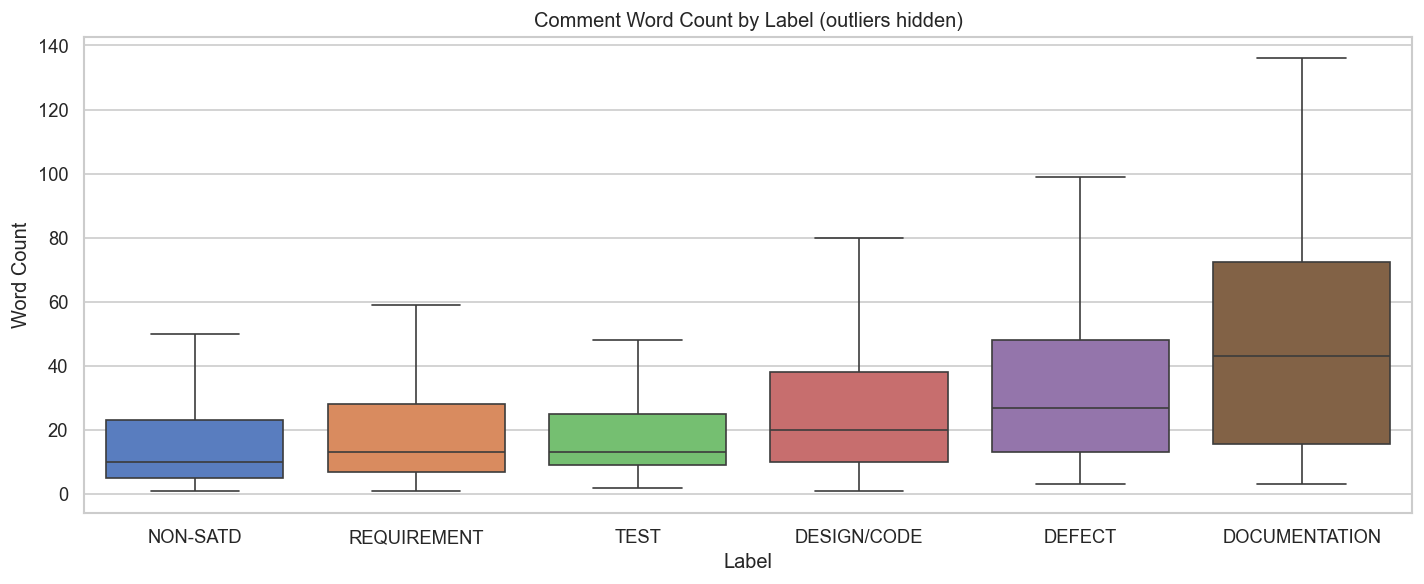

In [15]:
# Box plot: word count per label
fig, ax = plt.subplots(figsize=(12, 5))
order = df.groupby('manual_annotation')['comment_word_count'].median().sort_values().index
sns.boxplot(data=df, x='manual_annotation', y='comment_word_count',
            order=order, palette='muted', showfliers=False, ax=ax)
ax.set_title('Comment Word Count by Label (outliers hidden)')
ax.set_xlabel('Label')
ax.set_ylabel('Word Count')
plt.tight_layout()
plt.show()

## 9. SATD Keyword Analysis

In [16]:
SATD_KEYWORDS = [
    'TODO', 'FIXME', 'HACK', 'XXX', 'WORKAROUND', 'workaround',
    'BUG', 'TEMP', 'KLUDGE', 'future', 'FUTURE',
]

def has_keyword(text, keywords):
    text_upper = str(text).upper()
    return any(kw.upper() in text_upper for kw in keywords)

df['has_satd_keyword'] = df['commenttext'].apply(lambda t: has_keyword(t, SATD_KEYWORDS))

for kw in SATD_KEYWORDS:
    df[f'kw_{kw.lower()}'] = df['commenttext'].str.upper().str.contains(kw.upper(), regex=False)

kw_cols = [c for c in df.columns if c.startswith('kw_')]
kw_counts = df[kw_cols].sum().sort_values(ascending=False)
kw_counts.index = [c.replace('kw_', '').upper() for c in kw_counts.index]

print('Keyword frequencies:')
print(kw_counts)

Keyword frequencies:
TODO          8578
FIXME         2523
TEMP           643
BUG            577
HACK           461
WORKAROUND     281
FUTURE         272
XXX            203
KLUDGE           2
dtype: int64


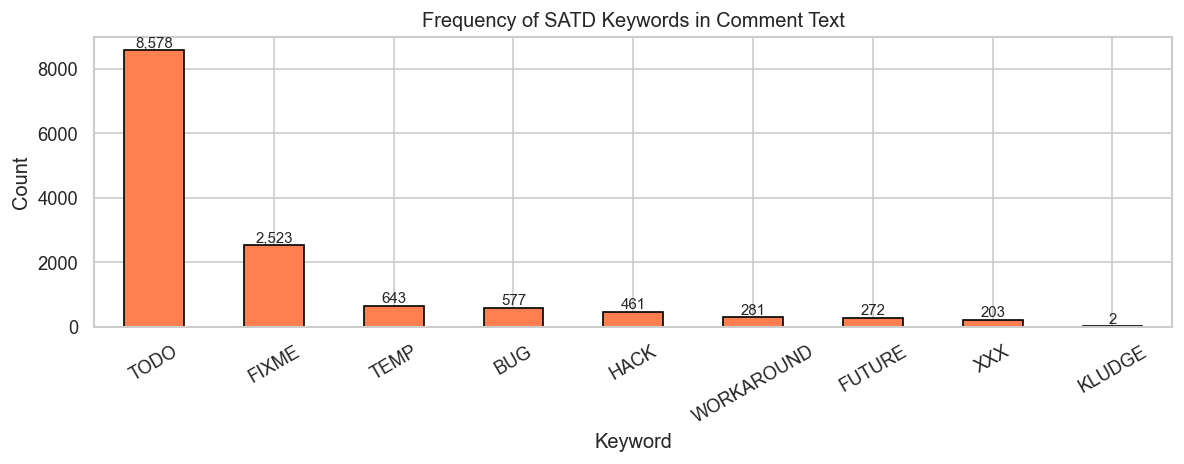

In [17]:
fig, ax = plt.subplots(figsize=(10, 4))
kw_counts.plot(kind='bar', ax=ax, color='coral', edgecolor='black')
ax.set_title('Frequency of SATD Keywords in Comment Text')
ax.set_xlabel('Keyword')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=30)
for p in ax.patches:
    if int(p.get_height()) > 0:
        ax.annotate(f'{int(p.get_height()):,}',
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

% of comments with at least one SATD keyword, by label:
manual_annotation
TEST             95.02
DOCUMENTATION    93.48
REQUIREMENT      93.18
DESIGN/CODE      87.84
DEFECT           85.75
NON-SATD          4.19
Name: has_satd_keyword, dtype: float64


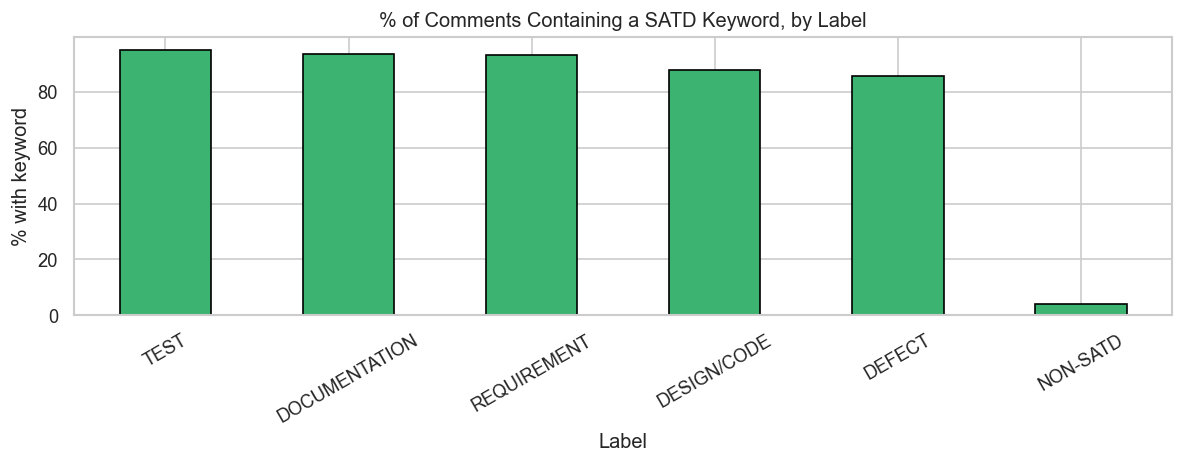

In [18]:
# Keyword presence by label
kw_label = df.groupby('manual_annotation')['has_satd_keyword'].mean() * 100
print('% of comments with at least one SATD keyword, by label:')
print(kw_label.sort_values(ascending=False).round(2))

fig, ax = plt.subplots(figsize=(10, 4))
kw_label.sort_values(ascending=False).plot(kind='bar', ax=ax,
                                             color='mediumseagreen', edgecolor='black')
ax.set_title('% of Comments Containing a SATD Keyword, by Label')
ax.set_ylabel('% with keyword')
ax.set_xlabel('Label')
ax.tick_params(axis='x', rotation=30)
plt.tight_layout()
plt.show()

## 10. Code Context Availability

In [19]:
df['has_preceding'] = df['preceding_code'].notna() & (df['preceding_code'].str.strip() != '')
df['has_succeeding'] = df['succeeding_code'].notna() & (df['succeeding_code'].str.strip() != '')

context_stats = pd.DataFrame({
    'Has Preceding Code': [df['has_preceding'].sum(), df['has_preceding'].mean()*100],
    'Has Succeeding Code': [df['has_succeeding'].sum(), df['has_succeeding'].mean()*100],
}, index=['Count', 'Percentage (%)'])
print(context_stats.round(2))

                Has Preceding Code  Has Succeeding Code
Count                     18228.00             31867.00
Percentage (%)               51.93                90.79


                   % with Preceding Code  % with Succeeding Code
manual_annotation                                               
DEFECT                             53.39                   95.70
DESIGN/CODE                        52.48                   95.68
DOCUMENTATION                      13.04                   89.13
NON-SATD                           50.64                   88.71
REQUIREMENT                        59.51                   92.03
TEST                               41.47                   87.44


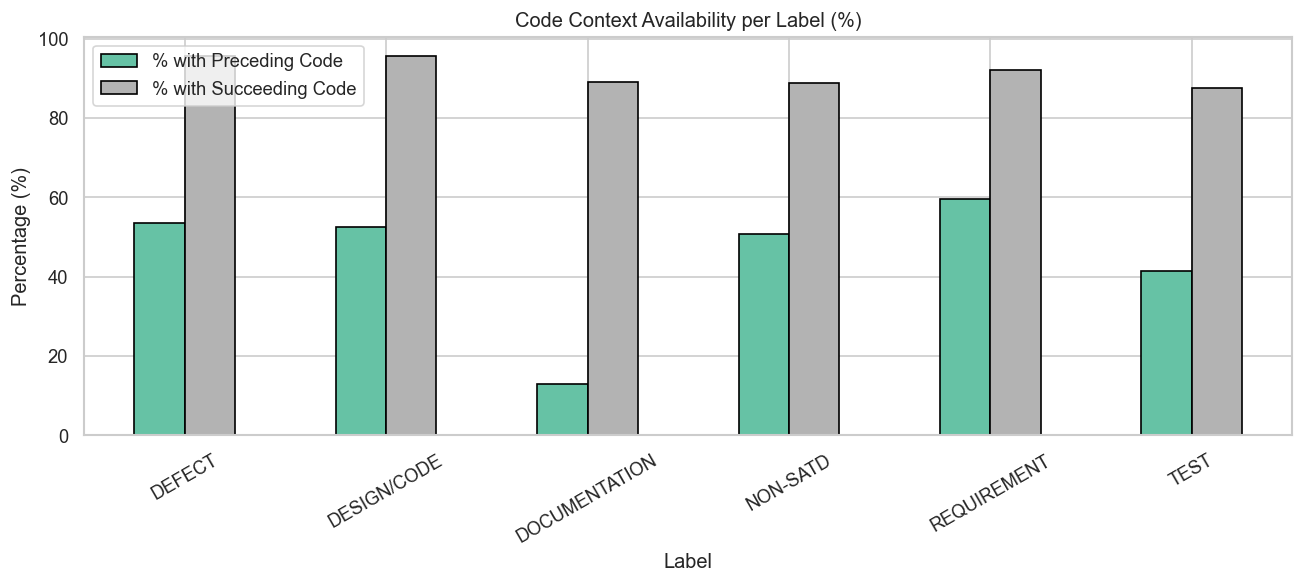

In [20]:
# Context availability per label
ctx_df = df.groupby('manual_annotation')[['has_preceding', 'has_succeeding']].mean() * 100
ctx_df.columns = ['% with Preceding Code', '% with Succeeding Code']
print(ctx_df.round(2))

ctx_df.plot(kind='bar', figsize=(11, 5), colormap='Set2', edgecolor='black')
plt.title('Code Context Availability per Label (%)')
plt.xlabel('Label')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=30)
plt.legend()
plt.tight_layout()
plt.show()

## 11. File-level Analysis

Total unique files: 9341
Avg comments per file: 3.76


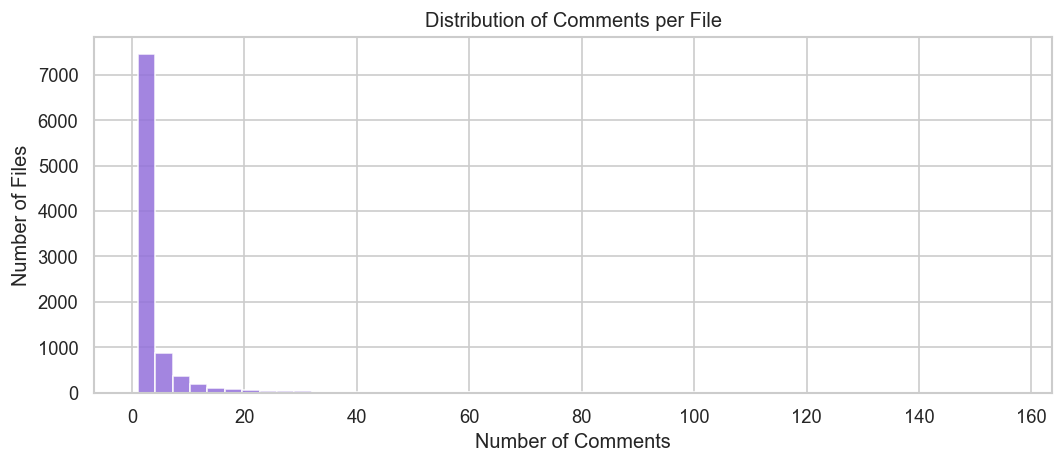

In [21]:
print(f'Total unique files: {df["file_id"].nunique()}')
print(f'Avg comments per file: {df.groupby("file_id").size().mean():.2f}')

comments_per_file = df.groupby('file_id').size()

fig, ax = plt.subplots(figsize=(9, 4))
ax.hist(comments_per_file, bins=50, color='mediumpurple', edgecolor='white', alpha=0.85)
ax.set_title('Distribution of Comments per File')
ax.set_xlabel('Number of Comments')
ax.set_ylabel('Number of Files')
plt.tight_layout()
plt.show()

Top 15 files by SATD comment count:
file_id
1195.h      101
508.cpp      78
537.cpp      65
1762.cpp     65
1909.cpp     46
232.cpp      42
2144.cpp     41
351.cpp      40
10403.cc     40
2346.cpp     37
1882.cpp     37
13534.cc     37
1297.cpp     37
1065.cpp     36
2223.cpp     36
dtype: int64


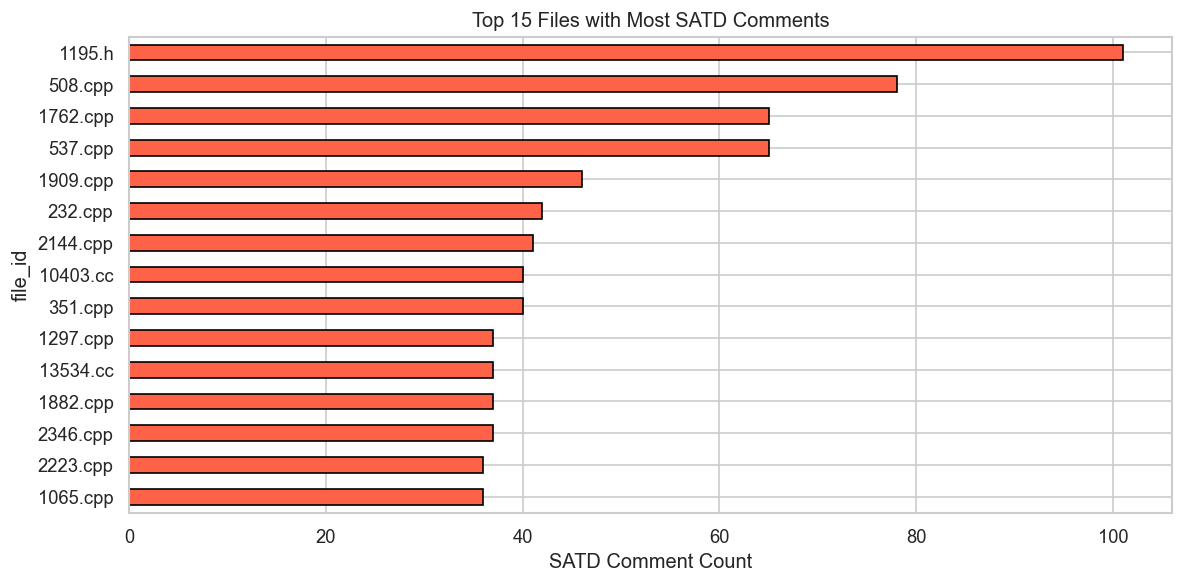

In [22]:
# Top 15 files by number of SATD comments
satd_labels = ['REQUIREMENT', 'DESIGN/CODE', 'DEFECT', 'TEST', 'DOCUMENTATION']
df['is_satd'] = df['manual_annotation'].isin(satd_labels)

top_satd_files = (
    df[df['is_satd']]
    .groupby('file_id').size()
    .sort_values(ascending=False)
    .head(15)
)
print('Top 15 files by SATD comment count:')
print(top_satd_files)

fig, ax = plt.subplots(figsize=(10, 5))
top_satd_files.sort_values().plot(kind='barh', ax=ax, color='tomato', edgecolor='black')
ax.set_title('Top 15 Files with Most SATD Comments')
ax.set_xlabel('SATD Comment Count')
plt.tight_layout()
plt.show()

## 12. SATD vs Non-SATD Balance

          Count  Percentage (%)
is_satd                        
NON-SATD  22029           62.76
SATD      13069           37.24


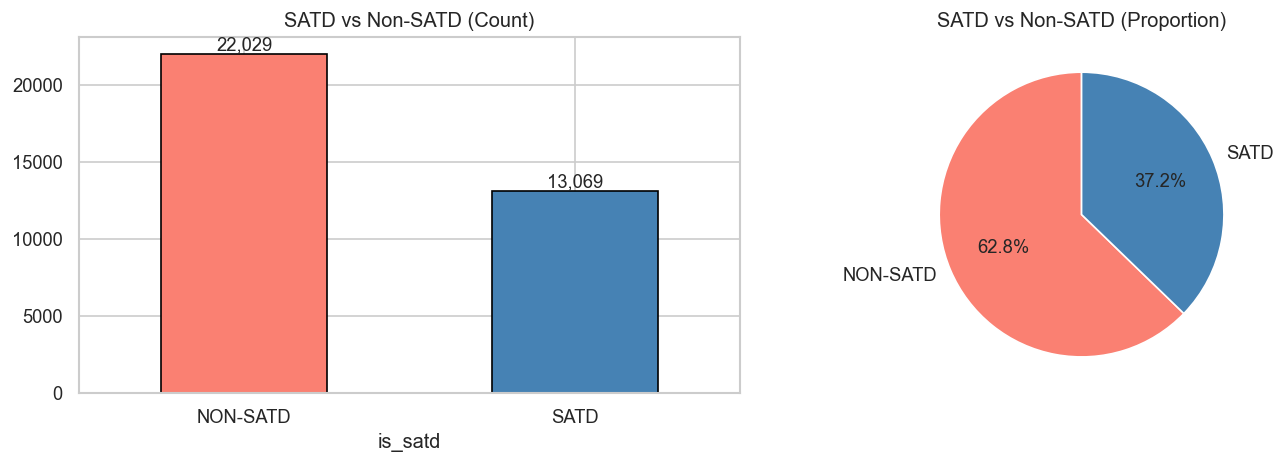

In [23]:
balance = df['is_satd'].value_counts().rename({True: 'SATD', False: 'NON-SATD'})
balance_pct = (balance / balance.sum() * 100).round(2)

print(pd.DataFrame({'Count': balance, 'Percentage (%)': balance_pct}))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
balance.plot(kind='bar', ax=axes[0], color=['salmon', 'steelblue'], edgecolor='black')
axes[0].set_title('SATD vs Non-SATD (Count)')
axes[0].set_xticklabels(balance.index, rotation=0)
for p in axes[0].patches:
    axes[0].annotate(f'{int(p.get_height()):,}',
                     (p.get_x() + p.get_width()/2, p.get_height()),
                     ha='center', va='bottom')

axes[1].pie(balance, labels=balance.index, autopct='%1.1f%%',
            colors=['salmon', 'steelblue'], startangle=90)
axes[1].set_title('SATD vs Non-SATD (Proportion)')
plt.tight_layout()
plt.show()

              NON-SATD   SATD
projectname                  
bitcoin          85.98  14.02
godot            76.40  23.60
react-native     63.30  36.70
swift            56.23  43.77
tensorflow       57.08  42.92


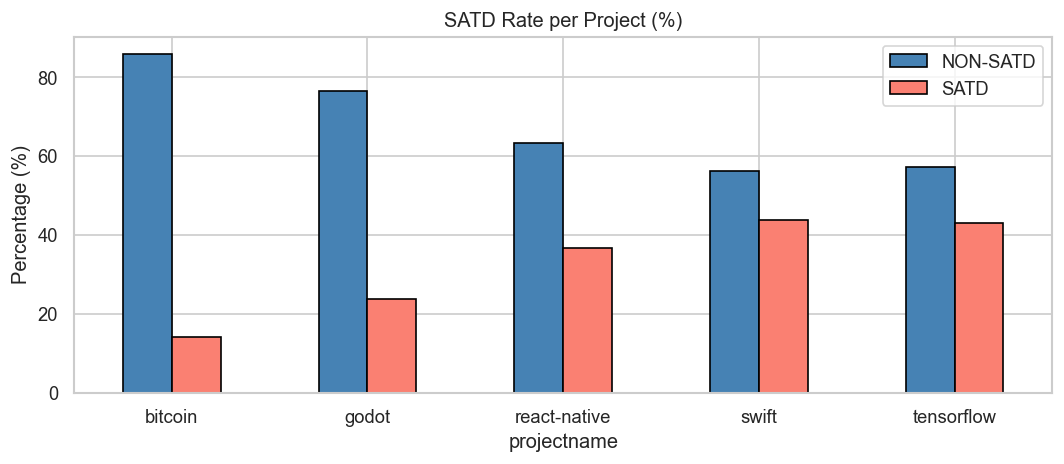

In [24]:
# SATD balance per project
satd_by_proj = df.groupby('projectname')['is_satd'].value_counts(normalize=True).unstack() * 100
satd_by_proj.columns = ['NON-SATD', 'SATD']
print(satd_by_proj.round(2))

satd_by_proj.plot(kind='bar', figsize=(9, 4), color=['steelblue', 'salmon'], edgecolor='black')
plt.title('SATD Rate per Project (%)')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)
plt.legend()
plt.tight_layout()
plt.show()

## 13. Comment Length vs SATD Type (Violin Plot)

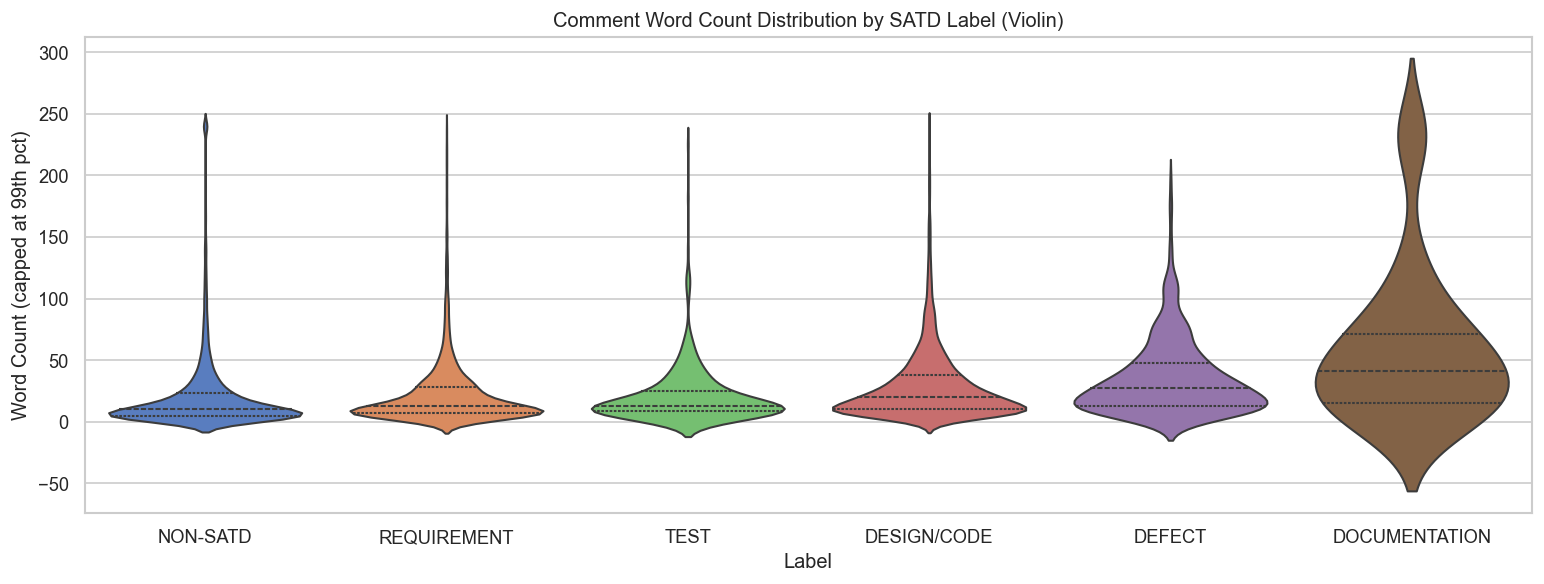

In [25]:
fig, ax = plt.subplots(figsize=(13, 5))
order = df.groupby('manual_annotation')['comment_word_count'].median().sort_values().index
sns.violinplot(
    data=df[df['comment_word_count'] < df['comment_word_count'].quantile(0.99)],
    x='manual_annotation', y='comment_word_count',
    order=order, palette='muted', inner='quartile', ax=ax
)
ax.set_title('Comment Word Count Distribution by SATD Label (Violin)')
ax.set_xlabel('Label')
ax.set_ylabel('Word Count (capped at 99th pct)')
plt.tight_layout()
plt.show()

## 14. Correlation & Feature Heatmap

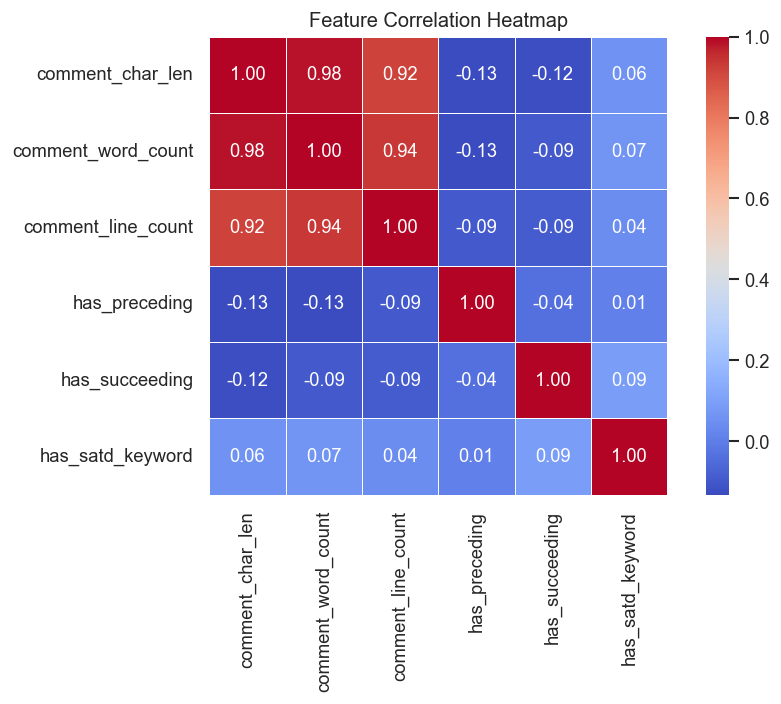

In [26]:
feature_cols = ['comment_char_len', 'comment_word_count', 'comment_line_count',
                'has_preceding', 'has_succeeding', 'has_satd_keyword']

corr = df[feature_cols].astype(float).corr()

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm',
            linewidths=0.5, square=True, ax=ax)
ax.set_title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

## 15. Duplicate Comment Detection

In [27]:
n_dup = df.duplicated(subset=['commenttext']).sum()
n_dup_id = df.duplicated(subset=['comment_id']).sum()

print(f'Duplicate comment_id rows : {n_dup_id}')
print(f'Duplicate commenttext rows: {n_dup}')
print(f'Duplicate (%) by text     : {n_dup/len(df)*100:.2f}%')

Duplicate comment_id rows : 2144
Duplicate commenttext rows: 4500
Duplicate (%) by text     : 12.82%


## 16. Sample Comments per Label

In [28]:
for label in df['manual_annotation'].unique():
    print(f'\n{'='*60}')
    print(f'  LABEL: {label}')
    print('='*60)
    samples = df[df['manual_annotation'] == label]['commenttext'].dropna().sample(
        min(3, (df['manual_annotation'] == label).sum()), random_state=42
    )
    for i, s in enumerate(samples, 1):
        snippet = str(s)[:300].replace('\n', ' ')
        print(f'  [{i}] {snippet}...')


  LABEL: NON-SATD
  [1] /**  * Argument type constants.  * Returned by Part.getArgType() for ARG_START and ARG_LIMIT parts.  *  * Messages nested inside an argument are each delimited by MSG_START and MSG_LIMIT,  * with a nesting level one greater than the surrounding message.  * @stable ICU 4.8  */...
  [2] // We don't know the value of the dimension, but we // know the rank of the input, so return the correct // rank with unknown dimensions....
  [3] /**  * @name variant_get_type  * @since 4.1  *  * Gets the type of a Variant.  *  * @param p_self A pointer to the Variant.  *  * @return The variant type.  */...

  LABEL: REQUIREMENT
  [1] /* Controls whether the new and experimental "dedicated dictionary search  * structure" can be used. This feature is still rough around the edges, be  * prepared for surprising behavior!  *  * How to use it:  *  * When using a CDict, whether to use this feature or not is controlled at  * CDict creat...
  [2] // A special GPU kernel for int32. // TOD

## 17. Summary Statistics

In [29]:
summary = pd.DataFrame({
    'Metric': [
        'Total rows',
        'Unique comment IDs',
        'Unique files',
        'Projects',
        'SATD labels',
        'Total SATD comments',
        'Total NON-SATD comments',
        'Median comment word count',
        'Comments with at least one SATD keyword',
        'Comments with preceding code context',
        'Comments with succeeding code context',
    ],
    'Value': [
        len(df),
        df['comment_id'].nunique(),
        df['file_id'].nunique(),
        df['projectname'].nunique(),
        df['manual_annotation'].nunique(),
        int(df['is_satd'].sum()),
        int((~df['is_satd']).sum()),
        int(df['comment_word_count'].median()),
        int(df['has_satd_keyword'].sum()),
        int(df['has_preceding'].sum()),
        int(df['has_succeeding'].sum()),
    ]
})

print(summary.to_string(index=False))

                                 Metric  Value
                             Total rows  35098
                     Unique comment IDs  32954
                           Unique files   9341
                               Projects      5
                            SATD labels      6
                    Total SATD comments  13069
                Total NON-SATD comments  22029
              Median comment word count     13
Comments with at least one SATD keyword  12636
   Comments with preceding code context  18228
  Comments with succeeding code context  31867
